# Image Sequence Generator for .npy

In [1]:
data_dir = '/Volumes/Samsung_T5/WeatherNet/Make_NP_DataSet/data_npy'

## Import modules

In [2]:
# A. General
import os

# B. Datafile manipulation
from PIL import Image
import pandas as pd
import glob 

# C. Numeric operations
import numpy as np 
from random import shuffle
from itertools import chain

# D. DataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# E. Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Declare paths to data

In [3]:
train_path = data_dir + "/train"
val_path = data_dir + "/val"
test_path = data_dir + "/train"

train_flir = train_path + "/flir"
train_top = train_path + "/top"
train_bottom = train_path + "/bottom"

val_flir = val_path + "/flir"
val_top = val_path + "/top"
val_bottom = val_path + "/bottom"

test_flir = test_path + "/flir"
test_top = test_path + "/top"
test_bottom = test_path + "/bottom"

In [4]:
# Get files in train
train_flir_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(train_flir+"/*.npy"))]
train_top_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(train_top+"/*.npy"))]
train_bottom_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(train_bottom+"/*.npy"))]

train_flir_files.sort()
train_top_files.sort()
train_bottom_files.sort()

if train_flir_files == train_top_files == train_bottom_files:
    print("ALL FILES EQUAL IN TRAIN! NICE!")
    
# Get files in val
val_flir_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(val_flir+"/*.npy"))]
val_top_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(val_top+"/*.npy"))]
val_bottom_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(val_bottom+"/*.npy"))]

val_flir_files.sort()
val_top_files.sort()
val_bottom_files.sort()

if val_flir_files == val_top_files == val_bottom_files:
    print("ALL FILES EQUAL IN VAL! NICE!")  
else: 
    a = set(val_flir_files) - set(val_top_files)
    a = a - set(val_bottom_files)
    print(a)
    
# Get files in test
test_flir_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(test_flir+"/*.npy"))]
test_top_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(test_top+"/*.npy"))]
test_bottom_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(test_bottom+"/*.npy"))]

test_flir_files.sort()
test_top_files.sort()
test_bottom_files.sort()

if test_flir_files == test_top_files == test_bottom_files:
    print("ALL FILES EQUAL IN TEST! NICE!")     
    

ALL FILES EQUAL IN TRAIN! NICE!
ALL FILES EQUAL IN VAL! NICE!
ALL FILES EQUAL IN TEST! NICE!


## Generator Class

In [40]:
class SeqDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, path_1, path_2, path_3, batch_size=32, dim=(6,32,32,32), 
                 n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.flir_path = path_1
        self.bottom_path = path_2
        self.top_path = path_3
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp,indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp,indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_flir = np.empty((self.batch_size, *self.dim))
        X_bottom = np.empty((self.batch_size, *self.dim))
        X_top = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X_flir[i,] = np.load(self.flir_path + '/' + ID)
            X_bottom[i,] = np.load(self.bottom_path + '/' + ID)
            X_top[i,] = np.load(self.top_path + '/' + ID)

        for i , index in enumerate(indexes):    
            # Store class
            y[i] = self.labels[index]
            
        return [X_flir,X_bottom,X_top], y

In [53]:
# Parameters
# dim ~ (# frames per seq, channels, height, width)
params = {'dim': (6,3,480,640),
          'batch_size': 1,
          'n_classes': 3,
          'shuffle': True}

# Datasets
input_train = [os.path.basename(name) for i,name in enumerate(glob.glob(train_flir+"/*.npy"))]
labels_train = [label.split("_")[-1] for i,label in enumerate(input_train)]
labels_train = [label.split(".")[0] for i,label in enumerate(labels_train)]

labels = ["low","mid","high"]

for i in range(len(labels_train)):
    if labels_train[i] == "low":
        labels_train[i] = 0
    elif labels_train[i] == "mid":
        labels_train[i] = 1
    else:
        labels_train[i] = 2           

# Generators
train_gen = SeqDataGenerator(input_train, labels_train,train_flir,\
                                      train_bottom,train_top, **params)

## View sample from generator

In [54]:
X, y = train_gen.__getitem__(0)
X_flir, X_bottom, X_top = X[0], X[1], X[2]
print(X_flir.shape)

(2, 6, 3, 480, 640)
(2, 6, 3, 480, 640)


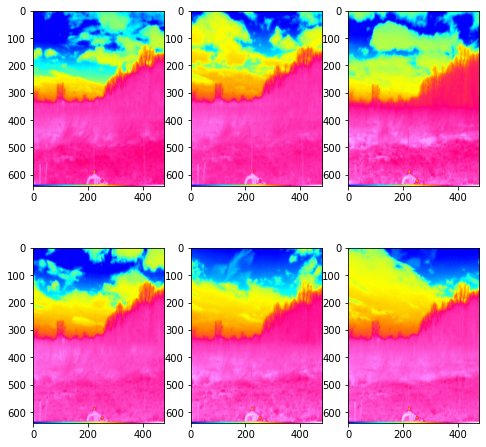

In [49]:
fig=plt.figure(figsize=(8,8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_flir[0,i-1,:,:,:].reshape(640,480,3).astype(int))
plt.show()

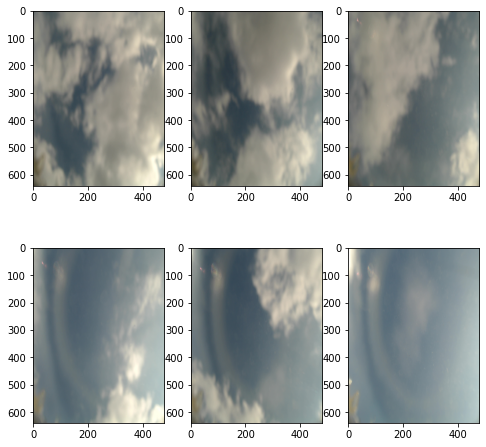

In [51]:
fig=plt.figure(figsize=(8,8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_top[0,i-1,:,:,:].reshape(640,480,3).astype(int))
plt.show()

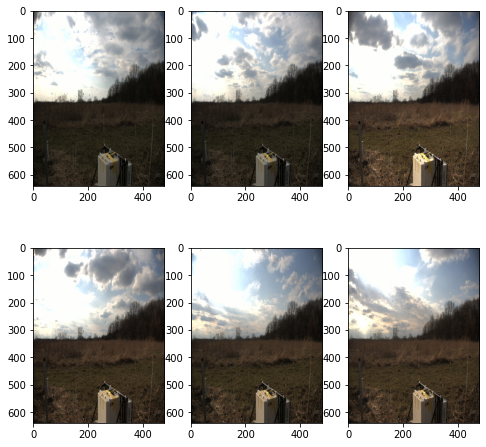

In [52]:
fig=plt.figure(figsize=(8,8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_bottom[0,i-1,:,:,:].reshape(640,480,3).astype(int))
plt.show()